In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()


/home/nlp/elronbandel/miniconda3/envs/squadlab/lib/python3.8/site-packages/tqdm/std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [52]:
!cat "e-shop clothing 2008 data description.txt"

Data description �e-shop clothing 2008�

Variables:

1. YEAR (2008)


2. MONTH -> from April (4) to August (8)


3. DAY -> day number of the month


4. ORDER -> sequence of clicks during one session


5. COUNTRY -> variable indicating the country of origin of the IP address with the 
following categories:

1-Australia
2-Austria
3-Belgium
4-British Virgin Islands
5-Cayman Islands
6-Christmas Island
7-Croatia
8-Cyprus
9-Czech Republic
10-Denmark
11-Estonia
12-unidentified
13-Faroe Islands
14-Finland
15-France
16-Germany
17-Greece
18-Hungary
19-Iceland
20-India
21-Ireland
22-Italy
23-Latvia
24-Lithuania
25-Luxembourg
26-Mexico
27-Netherlands
28-Norway
29-Poland
30-Portugal
31-Romania
32-Russia
33-San Marino
34-Slovakia
35-Slovenia
36-Spain
37-Sweden
38-Switzerland
39-Ukraine
40-United Arab Emirates
41-United Kingdom
42-USA
43-biz (*.biz)
44-com (*.com)
45-int (*.int)
46-net (*.net)
47-org (*.org)


6. SESSION ID -> variable indicating session id (short record)


7. PAGE 1 (MAIN CATEGORY) 

## Load Data

In [4]:
data = pd.read_csv('e-shop clothing 2008.csv', sep=';')

In [6]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
year,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008
month,4,4,4,4,4,4,4,4,4,4
day,1,1,1,1,1,1,1,1,1,1
order,1,2,3,4,5,6,7,8,9,1
country,29,29,29,29,29,29,29,29,29,29
session ID,1,1,1,1,1,1,1,1,1,2
page 1 (main category),1,1,2,2,2,3,3,4,4,2
page 2 (clothing model),A13,A16,B4,B17,B8,C56,C57,P67,P82,B31
colour,1,1,10,6,4,6,5,9,6,9
location,5,6,2,6,3,1,1,5,4,5


## Check if there are Missing Values

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165474 entries, 0 to 165473
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   year                     165474 non-null  int64 
 1   month                    165474 non-null  int64 
 2   day                      165474 non-null  int64 
 3   order                    165474 non-null  int64 
 4   country                  165474 non-null  int64 
 5   session ID               165474 non-null  int64 
 6   page 1 (main category)   165474 non-null  int64 
 7   page 2 (clothing model)  165474 non-null  object
 8   colour                   165474 non-null  int64 
 9   location                 165474 non-null  int64 
 10  model photography        165474 non-null  int64 
 11  price                    165474 non-null  int64 
 12  price 2                  165474 non-null  int64 
 13  page                     165474 non-null  int64 
dtypes: int64(13), object

<AxesSubplot:>

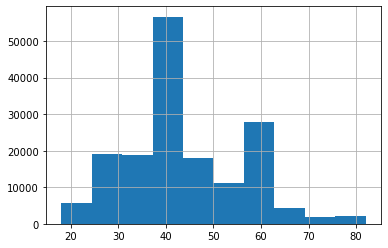

In [68]:
data.price.hist()

<AxesSubplot:>

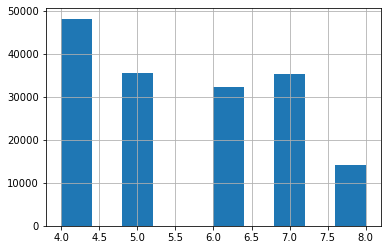

In [69]:
data.month.hist()

In [70]:
from collections import OrderedDict, defaultdict, Counter
from datetime import datetime
def get_features(row):
    return (f'{k}_{v}' for k, v in row.items())
def get_features_trans(row1, row2):
    return (f'{k}_{v1}+{v2}' for (k, v1), (_, v2) in zip(row1.items(), row2.items()))

day_type = {0:1,1:1,2:1,3:1,4:2,5:2,6:0}
new_data = []
for group, session in data.groupby('session ID'):
    #initial information
    res = session.iloc[0][['session ID', 'year', 'month', 'day', 'country']].to_dict(into=OrderedDict)
    #global informtation
    if res['country'] > 42:
        res['country'] = 43
    res['price_avg'] = session.price.mean()
    res['price_std'] = session.price.std()
    res['price2_avg'] = ((session['price 2'] * (-1)) + 2).mean()
    res['price_cat'] = int(res['price2_avg'] % 10)
    res['num_cats'] = session['page 1 (main category)'].nunique()
    res['num_items'] = session['page 2 (clothing model)'].nunique()
    res['num_colors'] = session.colour.nunique()
    res['week_day'] = datetime(res['year'], res['month'], res['day']).weekday()
    res['week_day_' + str(res['week_day'])] = 1
    res['week'] = int(res['day'] % 7)
    res['day_type_'+ str(day_type[res['week_day']])] = 1
    #features
    features_cols = ['page 1 (main category)', 'page 2 (clothing model)', 'colour', 'page', 'location']
    features_trans_cols = ['page 1 (main category)']
    for (indx1,row1),(indx2,row2) in zip(session[:-1].iterrows(),session[1:].iterrows()):
        if indx1 == 0:
            features = Counter(get_features(row1[features_cols]))
        features.update(get_features(row2[features_cols]))
        features.update(get_features_trans(row1[features_trans_cols], row2[features_trans_cols]))
        features['up_price'] += 1 if row1.price < row2.price else 0
        features['down_price'] += 1 if row1.price > row2.price else 0
    res.update(features)
    new_data.append(res)

In [71]:
processed = pd.DataFrame(new_data).fillna(0)

In [72]:
processed.head(10).T

,0,1,2,3,4,5,6,7,8,9
session ID,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
year,2008.0,2008.0,2008.0,2008.0,2008.0,2008.0,2008.0,2008.0,2008.0,2008.0
month,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
day,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
country,29.0,29.0,21.0,21.0,9.0,9.0,29.0,9.0,29.0,16.0
...,...,...,...,...,...,...,...,...,...,...
week_day_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
page 2 (clothing model)_P54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
page 2 (clothing model)_P28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
page 2 (clothing model)_P22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
list(processed.columns)

['session ID',
 'year',
 'month',
 'day',
 'country',
 'price_avg',
 'price_std',
 'price2_avg',
 'price_cat',
 'num_cats',
 'num_items',
 'num_colors',
 'week_day',
 'week_day_1',
 'week',
 'day_type_1',
 'page 1 (main category)_1',
 'page 2 (clothing model)_A13',
 'colour_1',
 'page_1',
 'location_5',
 'page 2 (clothing model)_A16',
 'location_6',
 'page 1 (main category)_1+1',
 'up_price',
 'down_price',
 'page 1 (main category)_2',
 'page 2 (clothing model)_B4',
 'colour_10',
 'location_2',
 'page 1 (main category)_1+2',
 'page 2 (clothing model)_B17',
 'colour_6',
 'page 1 (main category)_2+2',
 'page 2 (clothing model)_B8',
 'colour_4',
 'location_3',
 'page 1 (main category)_3',
 'page 2 (clothing model)_C56',
 'page_4',
 'location_1',
 'page 1 (main category)_2+3',
 'page 2 (clothing model)_C57',
 'colour_5',
 'page 1 (main category)_3+3',
 'page 1 (main category)_4',
 'page 2 (clothing model)_P67',
 'colour_9',
 'page 1 (main category)_3+4',
 'page 2 (clothing model)_P82',
 'p

In [74]:
processed.to_csv('data_processed.csv', index=False)